**Data: Хозяин руды**

В этом блокноте показана базовая модель для обучения поиска негабарита.

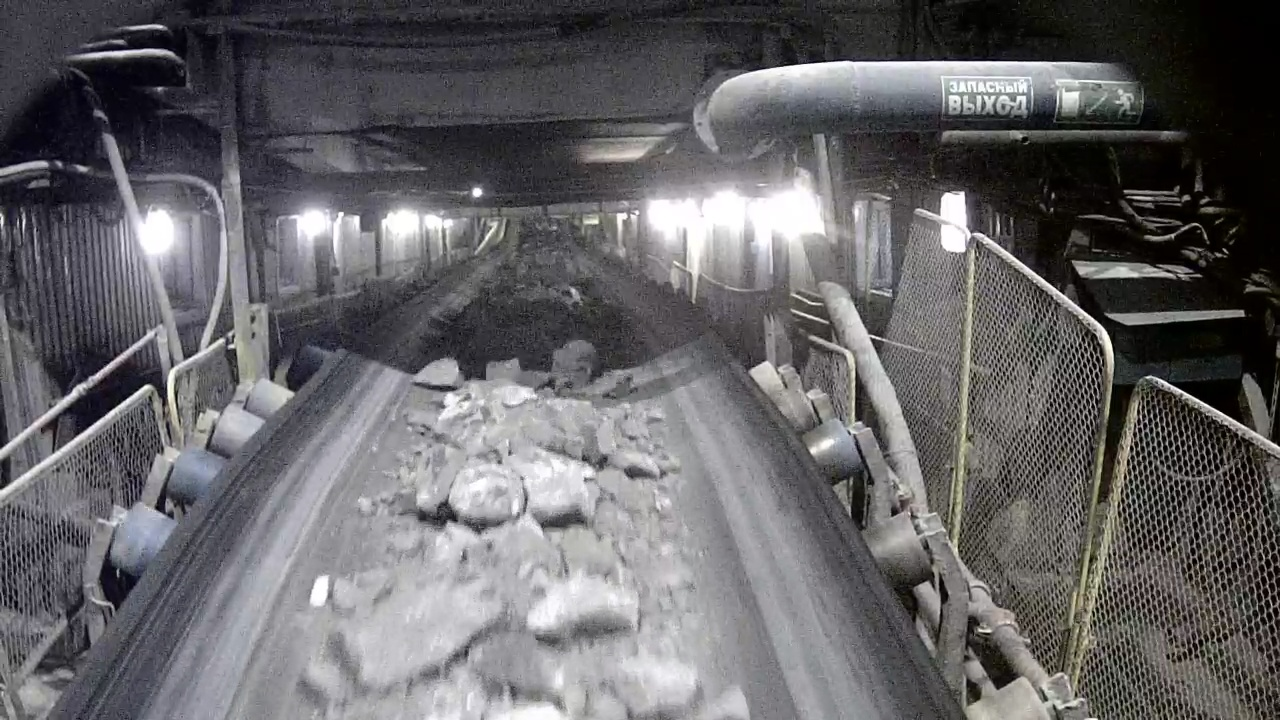

Результатом будет прогноз ограничевающих прямоугольников.

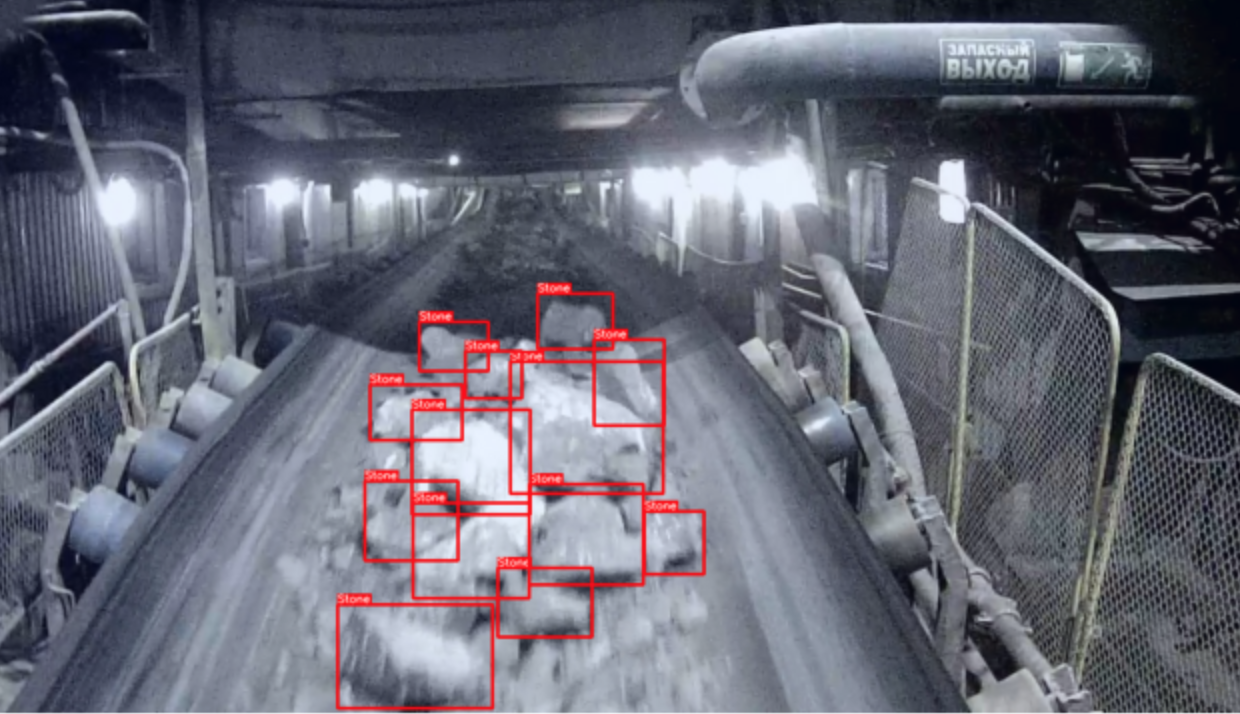




**Рекомендации по работе с проектом на хакатоне и идеи для развития:**
*   Данный блокнот имеет все базовые методы: загрузку датасета, обучение нейронной сети и выдача финального результата для загрузки на платформу.  Поэтому вам следует запустить все ячейки и убедиться, что вы правильно понимаете основную задачу.
*   Вы можете брать полностью этот проект за основу или создать свой с нуля. Можете использовать любой алгоритм, который посчитаете нужным. Не обязательно нейронную сеть.
*   Вам нужно увеличить точность работы нейронной сети или вашего алгоритма и максимально поднять итоговый скор.
*   Добавить классификацию величины блока исходя из размеров прямоугольника относительно ширины ленты. 7 классов брать из [таблицы (табл. 1)](https://pgenesis.notion.site/Data-de28e9bb758a4b608ac91ebf760feda3)
*   Продемонстрировать работу алгоритма в реалтайме на [видеопотоке mp4](https://drive.google.com/file/d/1IEx0YaCySK0rDy52wR6_KsiCWgC7wRTy/view?usp=sharing) - 
*   Если есть вопросы касательно этого блокнота, то пишите автору в телеграм [Владимиру](https://t.me/bums3230)
*   Приветсвуются любые идеи, которые могут касаться улучшения работы данного бизнес процесса. У экспертов трека можете получить фидбек о целесообразности ваших идей.

Топ-12 команд будут отобраны на питчи. Будет учитываться скор команд, а также идея решения и бизнес-ценность.

**Критерии оценки:**
*   50% - финальный скор. Корректность расположения ограничивающих прямоугольников.
*   30% - бизнес ценность. Классификации размеров гранул. Вычислислять размер гранул исходя из [таблицы (табл. 1)](https://pgenesis.notion.site/Data-de28e9bb758a4b608ac91ebf760feda3). Демонстрация работы алгоритма в реалтайме. 
*   10% - описание решения/документация. На сколько качественно описана архитектура решения, наличие сопроводительной документации. 
*   10% - презентация. На сколько понятно донесена идея и основные функции решения.


**Загружаем необходимые данные**

In [1]:
!wget -O dataset.zip http://77.244.221.121/dataset.zip
!unzip ./dataset.zip

# Библиотека для работы с COCO JSON
!pip install sahi

--2022-10-15 08:22:15--  http://77.244.221.121/dataset.zip
Connecting to 77.244.221.121:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 586204104 (559M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 559.05M  40.2MB/s    in 17s     

2022-10-15 08:22:32 (33.7 MB/s) - ‘dataset.zip’ saved [586204104/586204104]

Archive:  ./dataset.zip
   creating: dataset/
  inflating: dataset/.DS_Store       
   creating: __MACOSX/
   creating: __MACOSX/dataset/
  inflating: __MACOSX/dataset/._.DS_Store  
   creating: dataset/public/
  inflating: dataset/public/frame1361.jpg  
  inflating: dataset/public/frame1375.jpg  
  inflating: dataset/public/frame1349.jpg  
  inflating: dataset/public/frame1348.jpg  
  inflating: dataset/public/frame1374.jpg  
  inflating: dataset/public/frame1360.jpg  
  inflating: dataset/public/frame1389.jpg  
  inflating: dataset/public/frame1376.jpg  
  inflating: dataset/public/frame1362.jpg  
  inflating: d

In [2]:
!pip install pycocotools

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.5-cp37-cp37m-linux_x86_64.whl size=373765 sha256=ffc89dc47e60c36586883007d8f0c4f8df3984a548689be252f8eae84ea2e62e
  Stored in directory: /root/.cache/pip/wheels/85/c4/f0/7128093a134f590e4383fd60cb484960878721d98b9a515317
Successfully built pycocotools


**Подготовка класса для загрузки датасета**

In [3]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO
import numpy as np
import json
import glob
import pandas as pd
import os
import ast

In [4]:
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 14041, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 14041 (delta 36), reused 54 (delta 34), pack-reused 13982
Receiving objects: 100% (14041/14041), 13.30 MiB | 17.69 MiB/s, done.
Resolving deltas: 100% (9688/9688), done.


In [5]:
!pip install -r yolov5/requirements.txt

In [6]:
!mkdir yolov5/data/images/train
!mkdir yolov5/data/images/val
!mkdir yolov5/data/labels/
!mkdir yolov5/data/labels/train
!mkdir yolov5/data/labels/val

In [8]:
# train
json_file = "dataset/annot_local/test_annotation.json"
output = "yolov5/data/labels/val"


# val
# json_file = "dataset/annot_local/public_annotation_blank.json"
# output = "dataset/labels/public"

"""
将COCO instance数据集转为YOLO格式
"""
class COCO2YOLO:
    def __init__(self):
        self._check_file_and_dir(json_file, output)
        self.labels = json.load(open(json_file, 'r', encoding='utf-8'))
        self.coco_id_name_map = self._categories()
        self.coco_name_list = list(self.coco_id_name_map.values())
        # print(self.labels['images'][0])
        # print(self.labels['categories'][0])
        # print(self.labels['annotations'][0])
        print("total images", len(self.labels['images']))
        print("total categories", len(self.labels['categories']))
        print("total labels", len(self.labels['annotations']))

    def _check_file_and_dir(self, file_path, dir_path):
        if not os.path.exists(file_path):
            raise ValueError("file not found")
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

    def _categories(self):
        categories = {}
        for cls in self.labels['categories']:
            categories[cls['id']] = cls['name']
        return categories

    def _load_images_info(self):
        images_info = {}
        for image in self.labels['images']:
            id = image['id']
            file_name = image['file_name']
            w = image['width']
            h = image['height']
            images_info[id] = (file_name, w, h)

        return images_info

    def _bbox_2_yolo(self, bbox, img_w, img_h):
        # bbox矩形框, 左上角坐标 , 宽, 高
        x, y, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
        centerx = bbox[0] + w / 2
        centery = bbox[1] + h / 2
        dw = 1 / img_w
        dh = 1 / img_h
        centerx *= dw
        w *= dw
        centery *= dh
        h *= dh
        return centerx, centery, w, h

    def _convert_anno(self, images_info):
        anno_dict = dict()
        for anno in self.labels['annotations']:
            bbox = anno['bbox']
            image_id = anno['image_id']
            category_id = anno['category_id']

            image_info = images_info.get(image_id)
            image_name = image_info[0]
            img_w = image_info[1]
            img_h = image_info[2]
            yolo_box = self._bbox_2_yolo(bbox, img_w, img_h)

            anno_info = (image_name, category_id, yolo_box)
            anno_infos = anno_dict.get(image_id)
            if not anno_infos:
                anno_dict[image_id] = [anno_info]
            else:
                anno_infos.append(anno_info)
                anno_dict[image_id] = anno_infos
        return anno_dict

    def save_classes(self):
        sorted_classes = list(map(lambda x: x['name'], sorted(self.labels['categories'], key=lambda x: x['id'])))
        print('coco names', sorted_classes)
        with open('coco.names', 'w', encoding='utf-8') as f:
            for cls in sorted_classes:
                f.write(cls + '\n')
        f.close()

    def coco2yolo(self):
        print("loading image info...")
        images_info = self._load_images_info()
        print("loading done, total images", len(images_info))

        print("start converting...")
        anno_dict = self._convert_anno(images_info)
        print("converting done, total labels", len(anno_dict))

        print("saving txt file...")
        self._save_txt(anno_dict)
        print("saving done")

    def _save_txt(self, anno_dict):
        for k, v in anno_dict.items():
            file_name = v[0][0].split(".")[0] + ".txt"
            with open(os.path.join(output, file_name), 'w', encoding='utf-8') as f:
                print(k, v)
                for obj in v:
                    cat_name = self.coco_id_name_map.get(obj[1])
                    category_id = self.coco_name_list.index(cat_name)
                    box = ['{:.6f}'.format(x) for x in obj[2]]
                    box = ' '.join(box)
                    line = str(category_id) + ' ' + box
                    f.write(line + '\n')

c2y = COCO2YOLO()
c2y.coco2yolo()

total images 201
total categories 2
total labels 2314
loading image info...
loading done, total images 201
start converting...
converting done, total labels 201
saving txt file...
1 [('frame1800.jpg', 1, (0.2908854166666667, 0.4564814814814815, 0.0265625, 0.06481481481481481)), ('frame1800.jpg', 1, (0.2838541666666667, 0.37222222222222223, 0.03854166666666667, 0.044444444444444446)), ('frame1800.jpg', 1, (0.3247395833333333, 0.3736111111111111, 0.043229166666666666, 0.030555555555555558)), ('frame1800.jpg', 1, (0.32421875, 0.39490740740740743, 0.025520833333333333, 0.028703703703703703)), ('frame1800.jpg', 1, (0.30026041666666664, 0.3925925925925926, 0.028645833333333332, 0.04259259259259259)), ('frame1800.jpg', 1, (0.33984375, 0.49768518518518523, 0.04010416666666666, 0.03796296296296296)), ('frame1800.jpg', 1, (0.2700520833333333, 0.5467592592592593, 0.0484375, 0.0787037037037037)), ('frame1800.jpg', 1, (0.3614583333333333, 0.5486111111111112, 0.058333333333333334, 0.0527777777777777

In [9]:
# train
json_file = "dataset/annot_local/train_annotation.json"
output = "yolov5/data/labels/train"


# val
# json_file = "dataset/annot_local/public_annotation_blank.json"
# output = "dataset/labels/public"

"""
将COCO instance数据集转为YOLO格式
"""
class COCO2YOLO:
    def __init__(self):
        self._check_file_and_dir(json_file, output)
        self.labels = json.load(open(json_file, 'r', encoding='utf-8'))
        self.coco_id_name_map = self._categories()
        self.coco_name_list = list(self.coco_id_name_map.values())
        # print(self.labels['images'][0])
        # print(self.labels['categories'][0])
        # print(self.labels['annotations'][0])
        print("total images", len(self.labels['images']))
        print("total categories", len(self.labels['categories']))
        print("total labels", len(self.labels['annotations']))

    def _check_file_and_dir(self, file_path, dir_path):
        if not os.path.exists(file_path):
            raise ValueError("file not found")
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)

    def _categories(self):
        categories = {}
        for cls in self.labels['categories']:
            categories[cls['id']] = cls['name']
        return categories

    def _load_images_info(self):
        images_info = {}
        for image in self.labels['images']:
            id = image['id']
            file_name = image['file_name']
            w = image['width']
            h = image['height']
            images_info[id] = (file_name, w, h)

        return images_info

    def _bbox_2_yolo(self, bbox, img_w, img_h):
        # bbox矩形框, 左上角坐标 , 宽, 高
        x, y, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
        centerx = bbox[0] + w / 2
        centery = bbox[1] + h / 2
        dw = 1 / img_w
        dh = 1 / img_h
        centerx *= dw
        w *= dw
        centery *= dh
        h *= dh
        return centerx, centery, w, h

    def _convert_anno(self, images_info):
        anno_dict = dict()
        for anno in self.labels['annotations']:
            bbox = anno['bbox']
            image_id = anno['image_id']
            category_id = anno['category_id']

            image_info = images_info.get(image_id)
            image_name = image_info[0]
            img_w = image_info[1]
            img_h = image_info[2]
            yolo_box = self._bbox_2_yolo(bbox, img_w, img_h)

            anno_info = (image_name, category_id, yolo_box)
            anno_infos = anno_dict.get(image_id)
            if not anno_infos:
                anno_dict[image_id] = [anno_info]
            else:
                anno_infos.append(anno_info)
                anno_dict[image_id] = anno_infos
        return anno_dict

    def save_classes(self):
        sorted_classes = list(map(lambda x: x['name'], sorted(self.labels['categories'], key=lambda x: x['id'])))
        print('coco names', sorted_classes)
        with open('coco.names', 'w', encoding='utf-8') as f:
            for cls in sorted_classes:
                f.write(cls + '\n')
        f.close()

    def coco2yolo(self):
        print("loading image info...")
        images_info = self._load_images_info()
        print("loading done, total images", len(images_info))

        print("start converting...")
        anno_dict = self._convert_anno(images_info)
        print("converting done, total labels", len(anno_dict))

        print("saving txt file...")
        self._save_txt(anno_dict)
        print("saving done")

    def _save_txt(self, anno_dict):
        for k, v in anno_dict.items():
            file_name = v[0][0].split(".")[0] + ".txt"
            with open(os.path.join(output, file_name), 'w', encoding='utf-8') as f:
                print(k, v)
                for obj in v:
                    cat_name = self.coco_id_name_map.get(obj[1])
                    category_id = self.coco_name_list.index(cat_name)
                    box = ['{:.6f}'.format(x) for x in obj[2]]
                    box = ' '.join(box)
                    line = str(category_id) + ' ' + box
                    f.write(line + '\n')

c2y = COCO2YOLO()
c2y.coco2yolo()

total images 1299
total categories 1
total labels 17009
loading image info...
loading done, total images 1299
start converting...
converting done, total labels 1299
saving txt file...
101 [('frame101.jpg', 1, (0.39978515625, 0.616736111111111, 0.039179687500000004, 0.07108333333333333)), ('frame101.jpg', 1, (0.27925390625, 0.7586319444444445, 0.07049218750000001, 0.10423611111111111)), ('frame101.jpg', 1, (0.3703359375, 0.823152777777778, 0.05862500000000001, 0.0818888888888889)), ('frame101.jpg', 1, (0.41639843750000005, 0.7877916666666668, 0.046062500000000006, 0.09305555555555556)), ('frame101.jpg', 1, (0.5280703125, 0.8442500000000001, 0.06142187500000001, 0.08933333333333333)), ('frame101.jpg', 1, (0.458625, 0.7356805555555557, 0.06490625, 0.11291666666666667)), ('frame101.jpg', 1, (0.34555859375000003, 0.9208819444444446, 0.1486640625, 0.15823611111111113)), ('frame101.jpg', 1, (0.4133125000000001, 0.4971805555555555, 0.042, 0.04883333333333333)), ('frame101.jpg', 1, (0.366460937

In [10]:
import os
import shutil

file_names = os.listdir('yolov5/data/labels/val')
need_to_move = []
    
for file_name in file_names:
    need_to_move.append(file_name[:-4] + '.jpg')

for file_name in os.listdir('dataset/train'):
    if file_name in need_to_move:
        shutil.move(os.path.join('dataset/train', file_name), 'yolov5/data/images/val')
    else:
        shutil.move(os.path.join('dataset/train', file_name), 'yolov5/data/images/train')

In [11]:
os.remove('yolov5/data/images/bus.jpg')
os.remove('yolov5/data/images/zidane.jpg')

In [12]:
import yaml
data = {'train': './data/images/train',
'val': './data/images/val',
'nc': 2,
'names': ['0', '1']}
with open('./yolov5/data.yaml', 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False)

In [ ]:
!ls 'yolov5/data/labels/labels'

In [13]:
%cd yolov5

/kaggle/working/yolov5


In [17]:
!python train.py --img 645 --batch 1 --epochs 5 --data data.yaml --weights yolov5s.pt --cache

wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice: (30 second timeout) 
wandb: W&B disabled due to login timeout.
train: weights=yolov5s.pt, cfg=, data=data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=5, batch_size=1, imgsz=645, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.2-195-gdf80e7c Python-3.7.12 torch-1.11.0 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_d

In [18]:
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 416), started 0:13:03 ago. (Use '!kill 416' to kill it.)

In [25]:
from PIL import Image

In [28]:
!ls runs/train/exp2/results.csv

F1_curve.png					   results.png
PR_curve.png					   train_batch0.jpg
P_curve.png					   train_batch1.jpg
R_curve.png					   train_batch2.jpg
confusion_matrix.png				   val_batch0_labels.jpg
events.out.tfevents.1665822511.ab961460496f.441.0  val_batch0_pred.jpg
hyp.yaml					   val_batch1_labels.jpg
labels.jpg					   val_batch1_pred.jpg
labels_correlogram.jpg				   val_batch2_labels.jpg
opt.yaml					   val_batch2_pred.jpg
results.csv					   weights


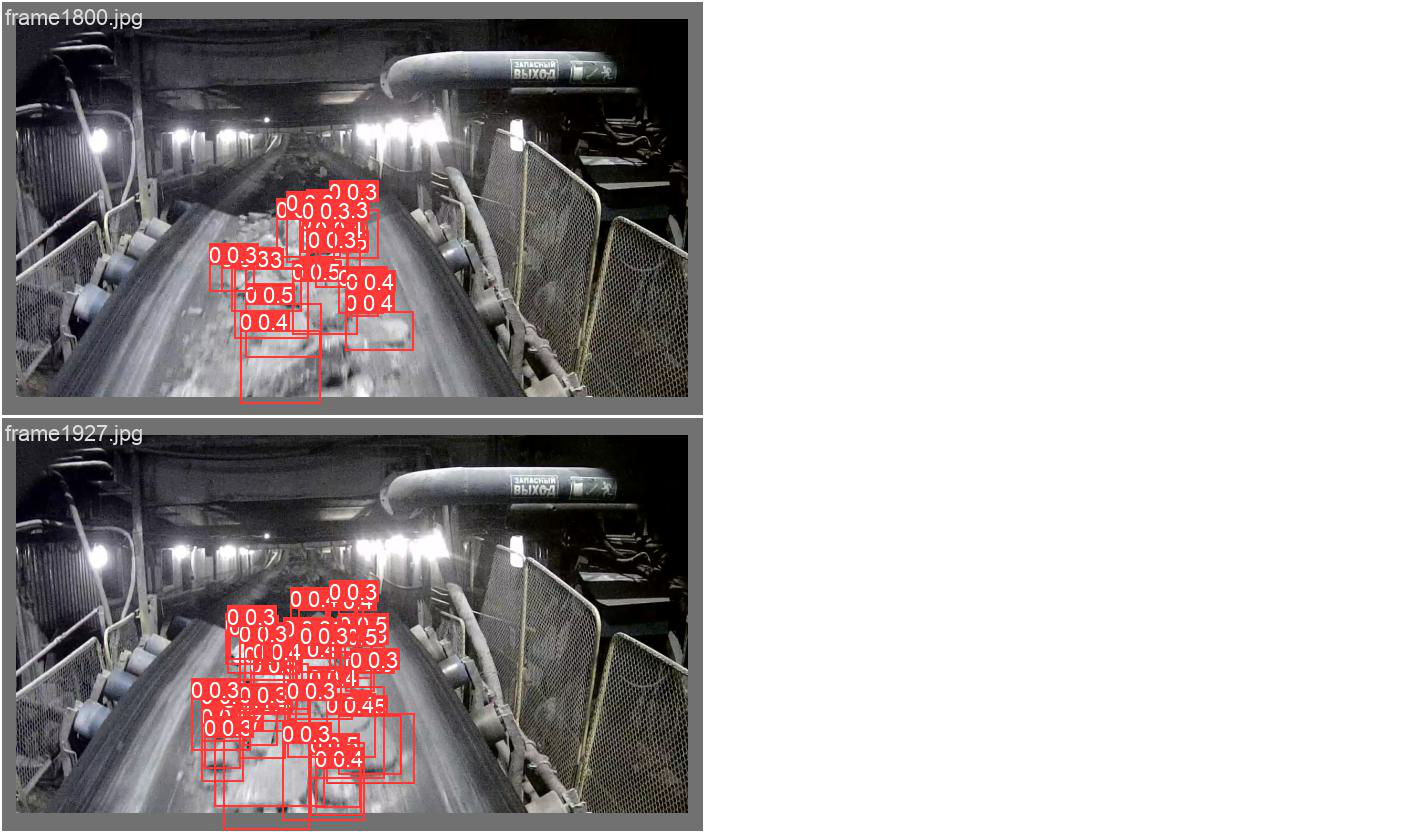

In [33]:
Image.open('runs/train/exp2/val_batch0_pred.jpg')

In [35]:
!ls runs/train/exp2/

F1_curve.png					   results.png
PR_curve.png					   train_batch0.jpg
P_curve.png					   train_batch1.jpg
R_curve.png					   train_batch2.jpg
confusion_matrix.png				   val_batch0_labels.jpg
events.out.tfevents.1665822511.ab961460496f.441.0  val_batch0_pred.jpg
hyp.yaml					   val_batch1_labels.jpg
labels.jpg					   val_batch1_pred.jpg
labels_correlogram.jpg				   val_batch2_labels.jpg
opt.yaml					   val_batch2_pred.jpg
results.csv					   weights


In [34]:
from utils.plots import plot_results 
plot_results('runs/train/exp2/results.csv')  # plot results.txt as results.png